# Convergence of the Reduced Basis Operator 

We are interested in the efficient numerical approximation of $(-\Delta)^s u$ for $s\in(0,1)$, where $(-\Delta)^s$ is the spectral fractional Laplacian on a bounded Lipschitz Domain $\Omega$. In this example, we choose $\Omega = \{\boldsymbol{x}\in\mathbb{R}^2: \|\boldsymbol{x}\| < 1\}$ to be the unit sphere and set
\begin{align*}
    u(\boldsymbol{x}) = (1-\|\boldsymbol{x}\|)*y^2*\sin(\|\boldsymbol{x}\|), \quad\boldsymbol{x} = (x,y),
\end{align*}
where $\|\cdot\|$ denotes the Euclidean norm.

In [1]:
#import all necessary libraries
from ngsolve import *
from netgen.geom2d import SplineGeometry
import numpy as np

importing NGSolve-6.2.2105


The domain is approximated through a quasi-uniform triangular mesh of mesh-size $h = 0.06$ using the mesh-generator NETGEN. In particular, the boundary $\partial\Omega$ is approximated using (non-curved) line segments. We highlight, however, that our theory equally holds true when curved elements are used.

In [2]:
geo = SplineGeometry()
geo.AddCircle((0,0),1, bc = "circle")
ngmesh = geo.GenerateMesh(maxh = 0.06)
mesh = Mesh(ngmesh)

To approximate the fractional Laplacian, we use a finite element space of polynomial order $2$ subject to homogeneous Dirichlet boundary conditions.

In [3]:
fes = H1(mesh, order = 2, dirichlet = "circle")

u, v = fes.TnT()
#mass matrix
M = BilinearForm(fes, symmetric = True)
M +=  SymbolicBFI(u * v)
#stiffness matrix
A = BilinearForm(fes, symmetric = True)
A +=  SymbolicBFI(grad(u) * grad(v))

M.Assemble()
A.Assemble()

We now approximate the function $u$ by its $L_2$-orthonormal projection onto the finite element space.

In [4]:
u_exact = LinearForm(fes)
u_exact += (1-sqrt(x*x+y*y)) * y**2 * sin(sqrt(x*x+y*y)) * v * dx 
u_exact.Assemble()

u = u_exact.vec.CreateVector()
u.data = M.mat.Inverse(fes.FreeDofs(), inverse = 'sparsecholesky') * u_exact.vec

For defining our reduced basis operator, we need to avail ourselves of the extremal eigenvalues (or good bounds for it) of the eigenvalue problem
\begin{align*}
    \langle \nabla \varphi_j, \nabla v \rangle_{L_2} = \lambda_j \langle \varphi_j, v \rangle_{L_2}
\end{align*}
for all $v$ being contained in the finite element space. Since the _exact_ eigenvalues of $-\Delta$ are given in closed form, we can bound the smallest eigenvalue by $1$. Hence, we set

In [5]:
lamL = 1

Good analytical bounds for the largest eigenvalue are not available. We therefore approximate it by power iteration. 

In [6]:
def PowerIteration(A, M, FreeDofs = None, tol = 1e-8, maxit = 1e4):
    
    tmp1 = BaseVector(A.width)
    tmp2 = tmp1.CreateVector()
    w = tmp1.CreateVector()
    w.FV().NumPy()[:] = np.random.rand(A.width)

    lamold = 0
    diff = 100
    counter = 0
    with TaskManager():
        Minv = M.Inverse(FreeDofs, inverse = "sparsecholesky")
        while (diff > tol and counter < maxit):
            tmp1.data = A * w
            tmp2.data = Minv * tmp1

            w.data = 1/sqrt(InnerProduct(tmp2,tmp2)) * tmp2
            lam = InnerProduct(w,tmp2)/InnerProduct(w,w)

            diff = abs(lam-lamold)
            lamold = lam
            counter += 1

        if (counter == maxit):
            print('RuntimeWarning: Power Iteration did not converge! Difference = ', diff)
                
        return lam
 
lamU = PowerIteration(A.mat, M.mat, FreeDofs = fes.FreeDofs()) + 1
print('The upper bound for the largest eigenvalue is given by lamU = ', lamU)

The upper bound for the largest eigenvalue is given by lamU =  49723.32001082151


Provided these quantities, we are now in position to introduce the reduced basis operator. According to Theorem 5, this is obtained by
\begin{align*}
    L_{H_r^s}u = V_rA_r^su_r,
\end{align*}
where $V_r$ is the columnwise arranged matrix that contains the orthonormal basis vectors of the reduced basis space, $u_r$ is the coordinate vector of u with respect to $V_r$, and $A_r = V_r^TAV_r$ is the compression of $A$.

In [7]:
from scipy.linalg import eigh

class ReducedBasisOperator():
    def __init__(self, u, FreeDofs, A, M, lamL, lamU):
       
        self.u = u
        #Create reduced basis
        self.basis = MultiVector(u, 1)
        self.basis[0].data = 1/sqrt(InnerProduct(u, M * u)) * u
        
        self.FreeDofs = FreeDofs
        self.M = M
        self.A = A
        self.lamL = lamL
        self.lamU = lamU
    
    #Input: new basis vector bv
    #Adds othonormalized vector to reduced basis  
    def Append(self, bv):
        self.basis.AppendOrthogonalize(bv, self.M)
        
        #reorthogonalize twice for numerical purposes
        self.basis.Orthogonalize(self.M)
        self.basis.Orthogonalize(self.M)
        
        #normalize orthogonalized vector
        norm = sqrt(InnerProduct(self.basis[-1], self.M * self.basis[-1]))
        self.basis[-1].data *= 1/norm

    #Input: -
    #Output: Dimension of reduced basis space
    def Dim(self):
        return len(self.basis)
  
    #Discards all basis vectors but the first one
    def Clear(self):
        tmp = self.u.CreateVector()
        tmp.data = self.basis[0]
        self.basis = MultiVector(self.u, 1)
        self.basis[0].data = tmp
    
    #Input: Coordinate vector vs
    #Output: Prolongation of vs
    def Prolongate(self, vs):
        v = self.u.CreateVector()
        v[:] = 0.0
        for i in range(self.Dim()):
            v.data += vs[i] * self.basis[i]
        return v

    #Input: Vector v
    #Output: M-othogonal projection of v onto the reduced basis space
    def Project(self, v):
        vs = Vector(self.Dim())
        for i in range(self.Dim()):
                vs[i] = InnerProduct(self.basis[i], self.M * v)
        return vs
      
    #Input: List of real numbers s = [s1, s2, ..., sk] contained in [0,1]     
    #Output: List of reduced basis approximation of L^s1 * u, L^s2 * u, ..., L^sk * u,
    #        where L is the negative Laplacian 
    def ApplyFractionalPower(self, s):
        u = [self.u.CreateVector() for i in range(len(s))]
        
        Ar = InnerProduct(self.basis, self.A * self.basis)
        evals, evecs = eigh(Ar)
        us = self.Project(self.u)
        for i,si in enumerate(s): 
            D = np.diag([abs(lam)**si for lam in evals])
            coef = evecs @ D @ np.transpose(evecs) @ us           
            u[i].data = self.Prolongate(coef)
            
        return u       
    
    #Input: List of real numbers, the so-called snapshots
    #Output: NGSolve MultiVector object whose elements form an orthonormal basis of the reduced basis space    
    def ComputeReducedSpace(self, snapshots, dispsolves = True):    
        self.Clear()
        
        tmp1 = self.u.CreateVector()
        tmp2 = self.u.CreateVector()
        
        tmp1.data = self.M * self.u
        Mat = self.M.CreateMatrix()
        MatInv = None
        for i,ti in enumerate(snapshots):
            if dispsolves: print('Progress: %d/%d\r'%(i+1, len(snapshots)), end = "")
            Mat.AsVector().data = self.M.AsVector() + ti * self.A.AsVector()
            if MatInv is None:
                MatInv = Mat.Inverse(self.FreeDofs, inverse = "sparsecholesky")
            else:
                MatInv.Update()
            tmp2.data = MatInv * tmp1
            self.Append(tmp2)
            
            
Lr = ReducedBasisOperator(u, fes.FreeDofs(), A.mat, M.mat, lamL, lamU)

Before proceeding with the reduced basis operator, we need to compute the snapshots, that is, the transformed Zolotarev points  $\hat{\mathcal{Z}}_1,\dots,\hat{\mathcal{Z}}_r$ on $[\lambda_U^{-1}, \lambda_L^{-1}],$ which are given by
\begin{align*}
    \hat{\mathcal{Z}_j} = \frac{\mathcal{Z}_j}{\lambda_L},\qquad  \mathcal{Z}_j = \text{dn}\left(\frac{2(r-j)+1}{2r}\mathcal{K}(\delta'),\delta'\right),\qquad \delta' = \sqrt{1-\delta^2},\qquad \delta = \frac{\lambda_L}{\lambda_U}
\end{align*}
for all $j = 1,\dots,r$, where $\text{dn}$ denotes the Jacobi elliptic function and $\mathcal{K}$ the complete elliptic integral of first kind. A numerical realization of these functions is provided in the scipy.special package: https://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special.

_Remark_: Note that the definition of $\mathcal{K}$ is not unique in the literature. In our paper, the argument of the elliptic integral is the elliptic modulus $k$. In many textbooks as well as in python, however, the
elliptic modulus $k$ is replaced by the parameter $m = k^2$.

_Note_: In the computation of the Zolotarev points, we need to compute the elliptic Integral with argument $\sqrt{1-\delta^2}$. If $\delta$ is small, the evaluation of $\mathcal{K}(\sqrt{1-\delta^2})$ is prone to rounding errors. In this regime, one should resort to the numerically more stable implementation of $\mathcal{K}$ using _ellipkm1_, see  https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ellipkm1.html?highlight=ellipkm1#scipy.special.ellipkm1

In [8]:
from scipy.special import ellipk, ellipj

#define Jacobi elliptic function
dn = lambda w,r : ellipj(w,r)[2]

def ComputeSnapshots(r, lamL, lamU):
    delta = lamL/lamU
    m = 1-delta**2
    K_ell = ellipk(m)
    Zhat = [ 1/lamL * dn( ( 2*(r-i) + 1 )/(2*r) * K_ell, m) for i in range(1,r+1) ]
        
    return Zhat

To compute a reference solution, we apply our reduced basis algorithm and choose $r$ large enough to neglect the arising inaccuracy.

In [9]:
s = [0.1,0.5,0.9]

snapshots = ComputeSnapshots(100, lamL, lamU)
Lr.ComputeReducedSpace(snapshots)
ref = Lr.ApplyFractionalPower(s)

Before we illustrate the performance of the reduced basis approximations, we compute its expected convergence rate which is encoded in the constant
\begin{align*}
    C^* = \frac{\pi \mathcal{K}(\mu_1)}{4\mathcal{K}(\mu)},\qquad \mu = \left(\frac{1-\sqrt{\delta}}{1+\sqrt{\delta}}\right)^2,\qquad \mu_1 = \sqrt{1-\mu^2}.
\end{align*}

In [10]:
delta = lamL/lamU
mu = (1-sqrt(delta))**4 / (1 + sqrt(delta))**4
mu1 = 1-mu**2
Cstar = pi * ellipk(mu1) / (4*ellipk(mu) )
print('Cstar = ', Cstar) 

Cstar =  0.4080941244238184


In [11]:
X = []
Error0 = []
Error1 = []
Error2 = []
Yref = []
diff = u.CreateVector()
num = 26
for r in range(1,num,2):
    print('Compute Reduced Space of dimension ', r+1)
    snapshots = ComputeSnapshots(r, lamL, lamU)
    Lr.ComputeReducedSpace(snapshots)
    sol = Lr.ApplyFractionalPower(s)

    diff.data = ref[0] - sol[0]
    Error0.append(sqrt(InnerProduct(diff, M.mat* diff)))

    diff.data = ref[1] - sol[1]
    Error1.append(sqrt(InnerProduct(diff, M.mat * diff)))

    diff.data = ref[2] - sol[2]
    Error2.append(sqrt(InnerProduct(diff, M.mat * diff)))

    X.append(r)
    Yref.append(10*exp(-Cstar*r))

Compute Reduced Space of dimension  2
Compute Reduced Space of dimension  4
Compute Reduced Space of dimension  6
Compute Reduced Space of dimension  8
Compute Reduced Space of dimension  10
Compute Reduced Space of dimension  12
Compute Reduced Space of dimension  14
Compute Reduced Space of dimension  16
Compute Reduced Space of dimension  18
Compute Reduced Space of dimension  20
Compute Reduced Space of dimension  22
Compute Reduced Space of dimension  24
Compute Reduced Space of dimension  26


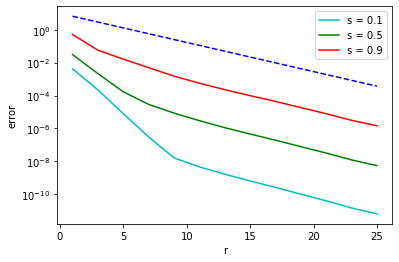

In [12]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(X,Error0, 'c', label = 's = 0.1')
plt.plot(X,Error1, 'g', label = 's = 0.5')
plt.plot(X,Error2, 'r', label = 's = 0.9')
plt.plot(X,Yref,'b--')
plt.xlabel('r')
plt.ylabel('error')
plt.legend()
plt.show()

# Sensitivity with respect to the Mesh Parameter

It is evident that the performance of our method relies on the condition of the problem, i.e., the ratio of the spectral bounds, and thus on the mesh parameter $h$. In the following, we plot the convergence rates of the reduced basis approximation for decreasing mesh parameter $h = 2^{-i}$, $i = 3,5,7$.

In [13]:
geo = SplineGeometry()
geo.AddCircle((0,0),1, bc = "circle")

#Smallest Eigenvalue remains uniformly bounded by 1
lamL = 1
s = [0.1]
#for plotting
X = []
i_start = 2
i_end = 5
Y = []
print('Starting mesh-refinements - this may take a few minutes')
for i in range(i_start,i_end):

    h = 1/(2**(2*i-1))
    print("h = ", h)
    ngmesh = geo.GenerateMesh(maxh = h)
    mesh = Mesh(ngmesh)

    fes = H1(mesh, order = 1, dirichlet = "circle")
    u, v = fes.TnT()

    M = BilinearForm(fes, symmetric = True)
    M +=  SymbolicBFI(u * v)
    A = BilinearForm(fes, symmetric = True)
    A +=  SymbolicBFI(grad(u) * grad(v))
    M.Assemble()
    A.Assemble()

    print('Compute spectral bound')
    lamU = PowerIteration(A.mat, M.mat, FreeDofs = fes.FreeDofs()) + 1

    u = BaseVector(M.mat.width)
    #Randomly initialize vector
    u.FV().NumPy()[:] = np.random.rand(M.mat.width)
    #enforce homogeneous Dirichlet BC
    for j, val in enumerate(fes.FreeDofs()):
            if val == 0: u[j] = 0

    print('Compute reference solution')
    Lr = ReducedBasisOperator(u, fes.FreeDofs(), A.mat, M.mat, lamL, lamU)
    snapshots = ComputeSnapshots(100, lamL, lamU)
    Lr.ComputeReducedSpace(snapshots, dispsolves = False)
    ref = Lr.ApplyFractionalPower(s)

    yi = []
    diff = u.CreateVector()
    print('Compute reduced basis approximations')
    for j in range(1,26):
        snapshots = ComputeSnapshots(j, lamL, lamU)
        Lr.ComputeReducedSpace(snapshots, dispsolves = False)
        u = Lr.ApplyFractionalPower(s)
        diff.data = ref[0] - u[0]
        error = sqrt(InnerProduct(diff, M.mat * diff))
        yi.append(error)
        
        if (i == i_start):
                X.append(j)
    Y.append(yi)


Starting mesh-refinements - this may take a few minutes
h =  0.125
Compute spectral bound
Compute reference solution
Compute reduced basis approximations
h =  0.03125
Compute spectral bound
Compute reference solution
Compute reduced basis approximations
h =  0.0078125
Compute spectral bound
Compute reference solution
Compute reduced basis approximations


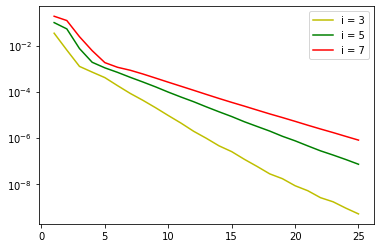

In [14]:
plt.yscale('log')
plt.plot(X,Y[0],'y', label = 'i = 3')
plt.plot(X,Y[1],'g', label = 'i = 5')
plt.plot(X,Y[2],'r', label = 'i = 7')
plt.legend()
plt.show()

As expected, the performance of our algorithm deteriorates (logarithmically) as the discrete operator becomes ill-conditioned.

# L-shape domain

To confirm that our analysis also holds true in the case of non-convex domains, we illustrate the performance of our reduced basis algorithm on the L-shape domain $\Omega = (0,1)^2\setminus([0.5,1]\times[0,0.5])$.

In [15]:
geo = SplineGeometry()

pnts =[(0,0),(1,0),(1,1),(0.5,1),(0.5,0.5),(0,0.5)]
p1,p2,p3,p4,p5,p6 = [geo.AppendPoint(*pnt) for pnt in pnts]
curves = [[["line",p1,p2],"1"],
          [["line",p2,p3],"2"],
          [["line",p3,p4],"3"],
          [["line",p4,p5],"4"],
          [["line",p5,p6],"5"],
          [["line",p6,p1],"6"]]
[geo.Append(c,bc=bc) for c,bc in curves]

ngmesh = geo.GenerateMesh(maxh = 0.02)
mesh = Mesh(ngmesh)

fes = H1(mesh, order = 1, dirichlet = "1|2|3|4|5|6")

u, v = fes.TnT()

M = BilinearForm(fes, symmetric = True)
M +=  SymbolicBFI(u * v)

A = BilinearForm(fes, symmetric = True)
A +=  SymbolicBFI(grad(u) * grad(v))

M.Assemble()
A.Assemble()

In this example, we set $u(\boldsymbol{x}) = 1$ to be the constant one function. 

In [16]:
u_exact = LinearForm(fes)
u_exact += 1 * v * dx 
u_exact.Assemble()

u = u_exact.vec.CreateVector()
u.data = M.mat.Inverse(fes.FreeDofs(), inverse = 'sparsecholesky') * u_exact.vec

The extremal eigenvalues are approximated using power iteration and the rational arnoldi algorithm. The latter is available in NGSolve.

In [17]:
lamU = PowerIteration(A.mat, M.mat, FreeDofs = fes.FreeDofs()) + 1

multidim = 20
EigenVec = [u.CreateVector() for i in range(multidim)]
Lam = ArnoldiSolver(A.mat, M.mat, fes.FreeDofs(), EigenVec, 0)
lamL = np.real(Lam[0])
        
print('lamU = ', lamU)
print('lamL = ', lamL)

n = 2252, m = 41 n*m*m = 3785612
Solve Hessenberg evp with Lapack ... done
lamU =  85055.36292259234
lamL =  38.68700682652776


In [18]:
s = [0.25, 0.5, 0.75]
Lr = ReducedBasisOperator(u, fes.FreeDofs(), A.mat, M.mat, lamL, lamU)
snapshots = ComputeSnapshots(100, lamL, lamU)
Lr.ComputeReducedSpace(snapshots)
ref = Lr.ApplyFractionalPower(s)

In [19]:
delta = lamL/lamU
mu = (1-sqrt(delta))**4 / (1 + sqrt(delta))**4
mu1 = 1-mu**2
Cstar = pi * ellipk(mu1) / (4*ellipk(mu) )
print('Cstar = ', Cstar)

Cstar =  0.5662791525430056


In [20]:
X = []
Error0 = []
Error1 = []
Error2 = []
Yref = []
diff = u.CreateVector()
num = 30
for r in range(1,num):
    print('Compute Reduced Space of dimension ', r+1)
    snapshots = ComputeSnapshots(r, lamL, lamU)
    Lr.ComputeReducedSpace(snapshots)
    sol = Lr.ApplyFractionalPower(s)
    
    diff.data = ref[0] - sol[0]
    Error0.append(sqrt(InnerProduct(diff, M.mat* diff)))
    
    diff.data = ref[1] - sol[1]
    Error1.append(sqrt(InnerProduct(diff, M.mat * diff)))
    
    diff.data = ref[2] - sol[2]
    Error2.append(sqrt(InnerProduct(diff, M.mat * diff)))
    
    X.append(r)
    Yref.append(10**3*exp(-Cstar*r))

Compute Reduced Space of dimension  2
Compute Reduced Space of dimension  3
Compute Reduced Space of dimension  4
Compute Reduced Space of dimension  5
Compute Reduced Space of dimension  6
Compute Reduced Space of dimension  7
Compute Reduced Space of dimension  8
Compute Reduced Space of dimension  9
Compute Reduced Space of dimension  10
Compute Reduced Space of dimension  11
Compute Reduced Space of dimension  12
Compute Reduced Space of dimension  13
Compute Reduced Space of dimension  14
Compute Reduced Space of dimension  15
Compute Reduced Space of dimension  16
Compute Reduced Space of dimension  17
Compute Reduced Space of dimension  18
Compute Reduced Space of dimension  19
Compute Reduced Space of dimension  20
Compute Reduced Space of dimension  21
Compute Reduced Space of dimension  22
Compute Reduced Space of dimension  23
Compute Reduced Space of dimension  24
Compute Reduced Space of dimension  25
Compute Reduced Space of dimension  26
Compute Reduced Space of dimensio

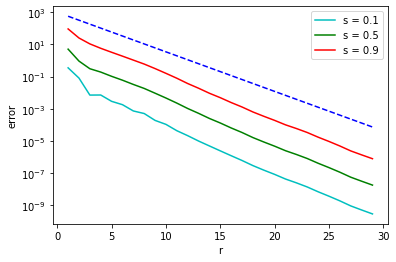

In [21]:
plt.yscale('log')
plt.plot(X,Error0, 'c', label = 's = 0.1')
plt.plot(X,Error1, 'g', label = 's = 0.5')
plt.plot(X,Error2, 'r', label = 's = 0.9')
plt.plot(X,Yref,'b--')
plt.xlabel('r')
plt.ylabel('error')
plt.legend()
plt.show()